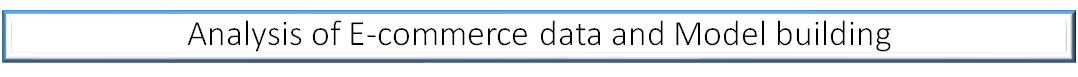

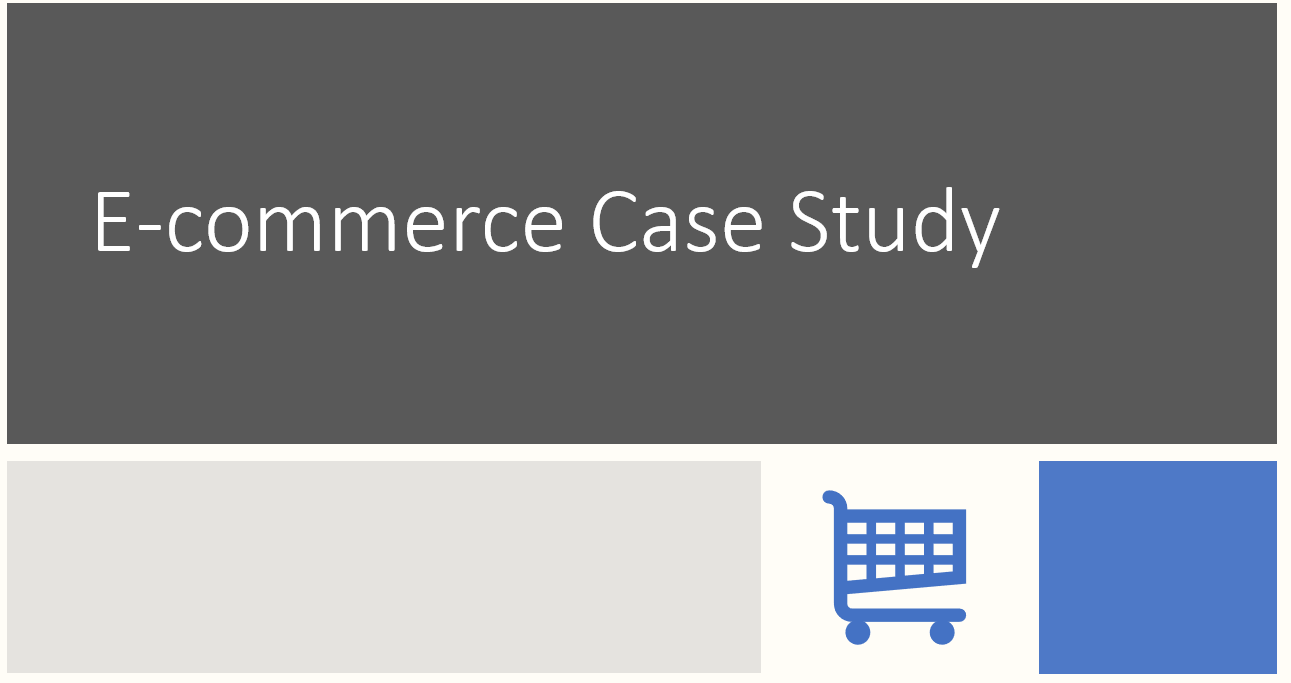

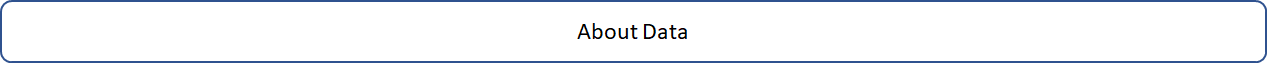

This data contains online retail store transaction from 38 countries by 4372 customers. There are 541,909 observations and 8 features for 53 weeks starting from 1st Dec 2010 to 9th Dec 2011.

|Variable|Description|Label & code| Type of Variable|
|:--|:--|:--|:--|
|InvoiceNo| Invoice Number or online order |-|<h1 style="color:blue; font-size:100%;">Nominal</h1>|
|StockCode| Code of product |-|<h1 style="color:blue; font-size:100%;">Nominal</h1>|
|Description|Description of each transaction|-| <h1 style="color:blue; font-size:100%;">Nominal</h1>|
|Quantity| Order quantity||<h1 style="color:red; font-size:100%;">Descreat</h1>|
|InvoiceDate|Date of order||<h1 style="color:red; font-size:100%;">Nominal</h1>|
|UnitPrice| Price of each respective product|-|<h1 style="color:blue; font-size:100%;">Continues</h1>|
|CustomerID| ID of each customer ||<h1 style="color:blue; font-size:100%;">Nominal</h1>|
|Country| Name of country of customers||<h1 style="color:blue; font-size:100%;">Nominal</h1>|

## What are the things we can see from this analysis?

This complete analysis is divided in 4 parts
*  Exploratory data analysis: which will have visual interpretation and will trying to understand purchase behaviour of customers by time delta and geography. We will also see some statistical hypothesis testing.
* Customer segmentation on LRFM data
* Weekly/Daily Time series Forecasting
* Sales prediction of new customer or estimates new sales of existing customers by Log-Log models

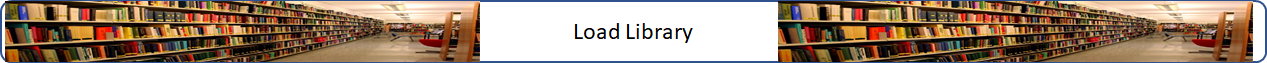

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets

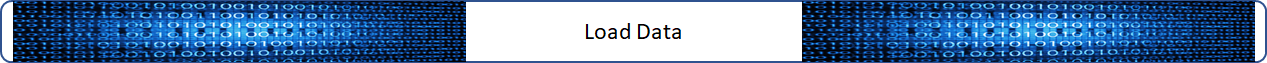

In [ ]:
data= pd.read_csv('/kaggle/input/ecommerce-data/data.csv',header=0,encoding="ISO-8859-1",engine='c')
print('Number of rows={0:.0f} and columns={1:.0f} \n'.format(data.shape[0],data.shape[1]))
print(data.info())

# First 5 rows of the data

In [ ]:
data.head()

As we can see that data type of invoice data is not correctly identified by pandas, so let’s convert that into datetime format and create other features in time dimension

In [ ]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
data['Sales'] = data.Quantity*data.UnitPrice
data['Year']=data.InvoiceDate.dt.year
data['Month']=data.InvoiceDate.dt.month
data['Week']=data.InvoiceDate.dt.isocalendar().week
data['Year_Month']=data.InvoiceDate.dt.to_period('M')
data['Hour']=data.InvoiceDate.dt.hour
data['Day']=data.InvoiceDate.dt.day
data['is_cancelled']=data.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
data['weekday'] = data.InvoiceDate.dt.day_name()
data['Quarter'] = data.Month.apply(lambda m:'Q'+str(ceil(m/4)))
data['Date']=pd.to_datetime(data[['Year','Month','Day']])
data.head()

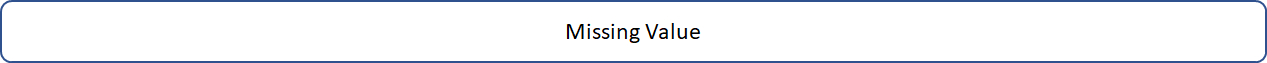
Only description and customer ID is missing. This shows that there 25% of transactions are not mapped to any customer which can be a bigger issue while identifying potential customers

In [ ]:
missing_data = data.isnull().sum().reset_index()
missing_data.columns=['Variables','missing_count']
#missing_data['Missing_perc']
missing_data['missing_perc']=missing_data.missing_count/data.shape[0]
print(missing_data)
del missing_data

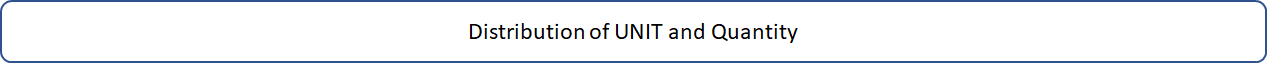
There are negative numbers under quantity hence sales are also negative. Negative number can be return transactions. Ideally, I should align each return with respective sales transaction and cancel out the entry. But for now, I will remove negative quantity for our further analysis.

In [ ]:

fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data.UnitPrice),row=1, col=1)
fig.add_trace(go.Box(y=data.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=data.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

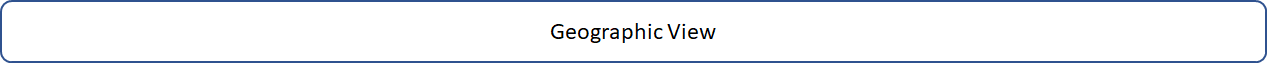
* United Kingdom has highest sales and it alone contributes 84% of total sales
* United Kingdom, Netherlands, EIRE (Republic of Ireland) , Germany, France, Australia, Spain are 7 countries which as 95% of total sales
* Netherlands has highest average sales per transaction compare to other countries
* United Kingdom has performed consistently each quarter followed by Netherlands whereas Germany which was on 6th Rank in Q1 2011 achieved 3rd rank in Q4 2011


In [ ]:
df = px.data.gapminder()
df = df [['country','iso_alpha']]
data = pd.merge(data,df[['country','iso_alpha']],left_on='Country',right_on='country',how='left').drop(columns=['country'])
del df

In [ ]:
grp_data = data.groupby(by='Country')['Sales'].sum().sort_values(ascending=False).reset_index()

fig = go.Figure(data=go.Choropleth(
    locations = grp_data['Country'],
    z = grp_data['Sales'],
    text = grp_data['Country'],
    colorscale = 'earth',
    locationmode = 'country names',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Sales',
))


fig.update_layout(
    title_text='Sales by country',
    geo=dict(showframe=False,showcoastlines=False,projection_type='equirectangular'),
    annotations = [dict(x=0.55,y=0.1,xref='paper',yref='paper',showarrow = False)])

fig.show()

del grp_data

### Lets delete negative quantity from the data and proceed with further analysis

In [ ]:
data_=data[data.is_cancelled=='No']
del data

# 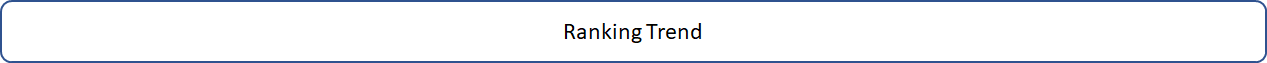

Quarterly ranking all countries. This chart will show how quarterly ranking of each country is changing with respect sales.

Note: - I was looking for a way to connect each circle with line so that I could connect ranking circle of each country. This may help viewer to identify country and their ranking easily. Currently work is in progress for this section.


In [ ]:
quarter_sales_country = data_.pivot_table(index='Country', columns='Quarter', values='Sales',aggfunc='sum').fillna(0)
rank_data = quarter_sales_country.apply(lambda x: x.rank(method='dense').astype(int)).reset_index()
rank_data['idx']=rank_data.index
rank_data = rank_data.melt(id_vars=['Country','idx'])

fig = px.scatter(rank_data , y="Country", x='Quarter', color="Country", hover_data=['Country']
                 ,size='value')
#fig.data[0].update(mode='markers+lines')
fig.update_layout(height=1500,width=700)
fig.show()

del [rank_data,quarter_sales_country]

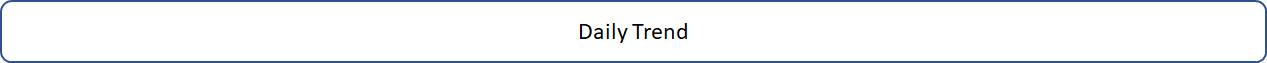
Due to presence of anomaly in the data, we can see some spike in the trend. There is no more detail available so it will be difficult to anticipate that this spike is due to any events or promotion. For now, lets assume that it is a random event.

In [ ]:
sales_by_date = data_.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

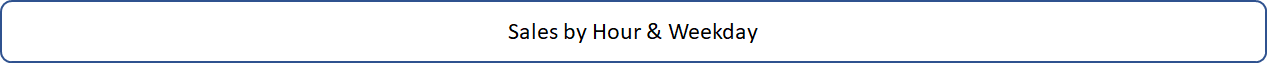

* Hourly sales are normally distributed and with mean 709k. 
* There is no pattern in day wise sales in a month.
* There is no business on Saturday.
* Average sales are consistent from Monday to Friday
* Sales starts at 6 in the morning and ends at 8 PM. 
* Peak hours of sales are between 10 AM to 3 PM
* Monday and Tuesday Sales starts at 7 AM and close at 6 PM
* Wednesday and Friday sales start at 7 AM and close at 8 PM
* Business hours for Sunday is between 9 to 4 PM



In [ ]:
sales_by_hour = data_.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = data_.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

In [ ]:
customer_by_month1 = data_.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = data_.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')


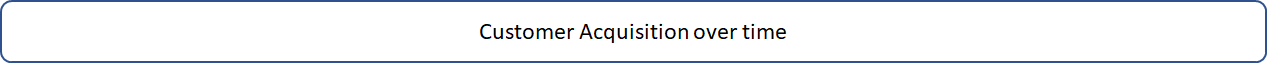

Below analysis exhibits the number of customer acquisition month over month and in the end of Nov 2011 there were approx. 4.2k customers who made their purchase during the given period.

In [ ]:

plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month

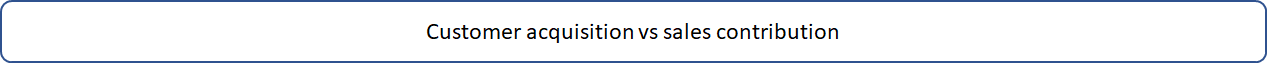

Lets see how old customers are contributing in total sales over time. Below charts shows that the quarter of customer acquisition and their total purchase in future years. Customer who made their first purchase in Q4 of Dec 2010 had large contribution in future quarter of 2011, same observation applies to the customers who were acquired in first quarter of 2011.

In [ ]:
customer_sales = data_.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

# Rpeat Purchase

* Most of customers made their next purchase after one or two months of first purchase
* There were 28 customers who made their first purchase in Dec 2010 also made their next purchase after 12 months
* 33 customers made their second purchase after 7 months of their first purchase in Mar 2011.

In [ ]:
cust_date =data_.loc[~data_.CustomerID.isna(),['CustomerID','Date']].drop_duplicates()
cust_date.sort_values(by=['CustomerID','Date'],inplace=True)
cust_date['rnk'] = cust_date.groupby(by='CustomerID')['Date'].transform('rank', method='dense')
cust_date = cust_date[cust_date.rnk<=2]
cust_date['Purchase'] = cust_date.rnk.map({1:'First Purchase',2:'Second Purchase'})

cust_purchase= cust_date.pivot(index='CustomerID',columns=['Purchase'],values='Date').reset_index()

cust_purchase['gap']=(cust_purchase['Second Purchase']- cust_purchase['First Purchase'])/ np.timedelta64(30, 'D')
cust_purchase['gap'] = cust_purchase['gap'].fillna(0).apply(lambda x:ceil(x))

days = pd.TimedeltaIndex(cust_purchase['First Purchase'].dt.day,unit="D")

cust_purchase['First_Purchase_month']=cust_purchase['First Purchase']- days+pd.DateOffset(days=1)
cust_purchase_grid = cust_purchase.pivot_table(index=['First_Purchase_month'],columns =['gap'],values='CustomerID',aggfunc='count').fillna(0)
cust_purchase_grid = cust_purchase_grid.sort_index( ascending=False)

fig = go.Figure(data=go.Heatmap(z=cust_purchase_grid
                                ,y=cust_purchase_grid.index,
                   x=cust_purchase_grid.columns.tolist(),
                   hoverongaps = True,colorscale='balance'))
fig.update_xaxes(side="top",showticklabels = True,ticktext= cust_purchase_grid.columns.tolist())
fig.update_layout(height=600,width=800,xaxis_title="Future Month of next Purchase after making first purchase"
                  ,yaxis_title="Month of 1st Purchase",
           yaxis=dict(autorange='reversed',showticklabels = True)
                  ,autosize=False,template='ggplot2')

fig.show()

del [cust_date,cust_purchase,days,cust_purchase_grid]

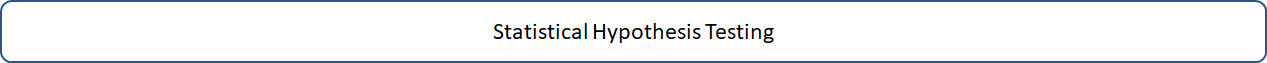

Below charts shows average sales by hours varies whereas average sales between 7AM to 10 AM is higher compare to other hours of the day. In right hand side chart, we can see that average sales on Sunday and Monday is low compare to other weekdays.

To proceed with further analysis, I would like to run few statistical tests to make sure the difference in average sales by hour and weekday are statistically significant


In [ ]:
sales_by_hour = data_.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = data_.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]

**Hour**

--------------------------------------------------------------------------

H0: Sales is same across hours from 6 AM to 10 PM

Ha: Sales varies by hour of the day

We can see that p value is less than .05 (a confidence threshold point to take risk). Hence, we can reject null hypothesis and concluded that average sales vary by hour of the day


In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=data_).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

**Weekday**

--------------------------------------------------------------------------

H0: Average Sales is same each weekday

Ha: Average Sales is not same for few days or all weekdays

This analysis also shows that p values is less than .05 , hence we can reject null hypothesis and conclude that average sales is different among weekdays.

In [ ]:
model = ols('Sales ~ C(weekday)',data=data_).fit()
#moore_lm.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)

del [table,model]


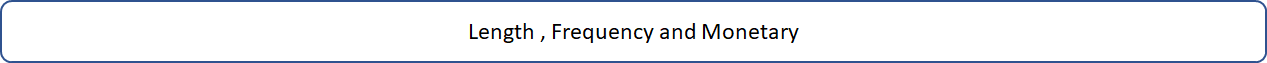

As we know data has hourly transaction. For this analysis I will aggregate data at customer level and will create below features.

* Length of Stay = How long customer has been associated with business
* Frequency = How many times customer has given order in duration given in the data
* Monitory = Sales amount generated by each customer



In [ ]:
LRFM = data_.groupby('CustomerID').agg(Frequency=pd.NamedAgg(column="InvoiceNo", aggfunc="nunique")
                                        ,Monetary=pd.NamedAgg(column="Sales", aggfunc="sum")).reset_index()

length = data_.groupby('CustomerID')['Date'].max() - data_.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length_of_stay']
LRFM = LRFM.merge(length,on='CustomerID',how='inner')
del length

LRFM.head()

# 3 D View of Sales vs Length of Stay vs Frequency
This chart shows that there are set of potential customers who has influential data points. This gives an intuition of finding cluster in the data.


In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=LRFM.Monetary,y=LRFM.Length_of_stay,z=LRFM.Frequency,mode='markers'
                                   ,marker=dict(size=4,color='coral',colorscale='Viridis',opacity=0.8))])
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Frequency')),width=800,height=500)
fig.show()

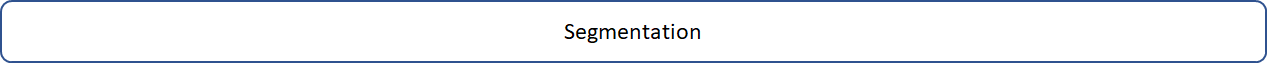

#### Objective of this analysis is to find pattern in the data which can group customers based on certain statistical rules. Variables which are being used are Recency, Monitory and length of stay. Below is the detailed explanation of these features


#### Steps

* Run iteration for number of clusters to select optimal clusters
* Get Error and Silhouette Distance and plot
* Select optimal number of cluster and create group
* Plot Silhouette values with respect to different sample size
* Create Profile of customers by group
* Create 3 D view of features divided by group
* Create bi variate scatter plot coloured by group
* Create two-dimensional view of points by t-SNE


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

# Iteration for Kmeans

In [ ]:
X=LRFM.drop(columns = 'CustomerID')
error = []
silhouette = []
np.random.seed(12)
rng = range(2,20)
for i in rng:
    km = KMeans(n_clusters=i, init='random',n_init=20, max_iter=200,tol=.0001, random_state=12)
    km.fit(X)
    error.append(km.inertia_)
    lbls = km.fit_predict(X)
    silhouette.append(silhouette_score(X, lbls))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Number of Cluster vs Error", "Number of Cluster vs Silhouette"))
fig.add_trace(go.Scatter(x=list(rng), y=error),row=1, col=1)
fig.add_trace(go.Scatter(x=list(rng), y=silhouette),row=1, col=2)
fig.update_layout(height=500, width=800,template='ggplot2')
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Errors", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Distance", row=1, col=2)
fig.show()

del [error,silhouette,rng,km,lbls,X]

# Create Clusters
I have selected 10 clusters to start with and understand how customers' profile look like. We can do several statistical tests to get optimal cluster size.

In [ ]:
X=LRFM.drop(columns = 'CustomerID')
cluster_lbls = KMeans(n_clusters=10, random_state=12).fit_predict(X)
X['cluster'] = cluster_lbls
X['sample_silhouette_values'] = silhouette_samples(X, cluster_lbls)
X['txt']=X.cluster.apply(lambda x:'Cluster '+str(x))

# Silhouette vs Sample
This gives glimpse of Silhouette values with respect outlier present in the data.

In [ ]:

fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.sample_silhouette_values
                                , mode='markers',marker_color=X.cluster,text = X.txt))

fig.update_layout(xaxis_title="Sales",yaxis_title="Silhouette"
                  ,title='Sample Size vs Silhoutte Values')

fig.show()


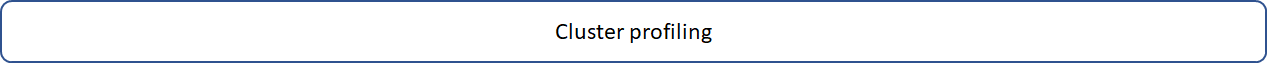
Charts show the group vs average sales and number of customers belong to the group. 
Customers from Cluster 1 and 5 can be considered on high priority and can be offered some promotions so that they can continue their association with business. Whereas customers from cluster 3, 7 and 9 can be treated as medium size customer. 

For medium size customers we can understand their purchase pattern and provide some promotions accordingly.

In the end we have list of customers from remaining clusters who can be taken as seriously and if we see their length of stay is better than medium size customers but their order size and order frequency is very low. So, we may understand their purchases pattern, type of product they select, and we can offer them some discounts or vouchers, or we can do some cross sales with them.


In [ ]:
df = X.groupby('cluster').agg({'cluster':'size', 'Monetary':'mean','Frequency':'mean','Length_of_stay':'mean'}) \
       .rename(columns={'cluster':'Size','Monetary':'Avg Sales','Frequency':'Avg Recency','Length_of_stay':'Avg Lenght of Stay'}) \
       .reset_index().sort_values(by = 'Avg Sales')

cluster_map ={'Cluster 4':'lightskyblue','Cluster 0':'lightskyblue','Cluster 8':'lightskyblue'
              ,'Cluster 6':'lightskyblue','Cluster 2':'lightskyblue',
             'Cluster 3':'orange','Cluster 7':'orange','Cluster 9':'orange'
              ,'Cluster 1':'olive','Cluster 5':'olive'}

txt =['Size = {0:.0f}'.format(i) for i in df.Size]
df['cluster']=df.cluster.apply(lambda x:'Cluster '+str(x))
df['Group']=df.cluster.map(cluster_map)

fig = make_subplots(rows=1, cols=3,subplot_titles=("Avg Sales", "Avg Recency",'Avg Lenght of Stay'))

fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Sales'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Recency'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=2)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Lenght of Stay'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=3)

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title_text='Cluster Size',width = 800,height=600,template='ggplot2'
                  ,font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.show()


# 3 D view of clusters

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=X.Monetary,y=X.Length_of_stay,z=X.Frequency,mode='markers'
                                   ,marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Recency')),width=700,height=500)
fig.show()

# Bivariate View of by Segment

In [ ]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Length_of_stay
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Length of Stay",title='Sales vs Length of Stay'
                  ,width=800,height=500)
fig.show()

In [ ]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Frequency
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Frequency",title='Sales vs Frequency'
                  ,width=800,height=500)
fig.show()

# t-distributed Stochastic Neighbor Embedding.
t-SNE is a method to visualize high dimensional data in two dimensions
if the value of perplexity (It is the value to select nearest neighbors which will generate different samples) is more than 30 then algorithm is able to separate the points clearly.

In [ ]:
prpxlt = [10,15,30,40]
fig = make_subplots(rows=2, cols=2,subplot_titles=['perplexity = %s'%i for i in prpxlt])

for i, prpxlt_ in enumerate(prpxlt):
    X_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=prpxlt_).fit_transform(X[['Frequency', 'Monetary', 'Length_of_stay']])
    if i%2==0:
        c=2
    else:
        c=1
    r = (i)//2+1
    fig.add_trace(go.Scatter(x=X_tsne[:,0],y=X_tsne[:,1]
                                    , mode='markers',marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8),text=X.txt),row=r, col=c)

    fig.update_xaxes(title_text="Component 1", row=r, col=c)
    fig.update_yaxes(title_text="Component 2", row=r, col=c)
    
fig.update_layout(height=600, width=800)
fig.show()

del [X_tsne,fig]

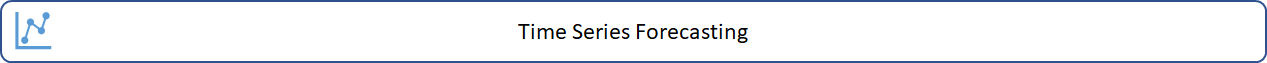
Models which I have tried are not perfect one and certainly there are scope to improve the performance.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [ ]:
ds_weekly = data_.groupby(by=['Year','Week'])['Sales'].sum().reset_index()
ds_daily = data_.groupby(by=['Date'])['Sales'].sum().reset_index()

In [ ]:
def plot_(t_train,t_test,x_train,x_test,x_train_pred,x_test_pred,forecast,title='Weekly'):
    xt = (max(t_test)+np.arange(len(forecast)))+1
    fig_train=go.Scatter(name='Train : Actual ',x=t_train,y=x_train,showlegend=True)
    fig_trian_pred=go.Scatter(name='Train : Predict',x=t_train,y=x_train_pred,showlegend=True)
    fig_test=go.Scatter(name='Test : Actual',x=t_test,y=x_test,showlegend=True)
    fig_test_pred=go.Scatter(name='Test : Predict',x=t_test,y=x_test_pred,showlegend=True)
    fig_forecast=go.Scatter(name='Forecast',x=xt,y=forecast,showlegend=True)

    fig = go.Figure([fig_train,fig_trian_pred,fig_test,fig_test_pred,fig_forecast])
    fig.update_layout(xaxis_title=title,yaxis_title="Sales",title=title +' Trend'
                      ,height=400,hovermode="x",template='ggplot2')
    fig.show()

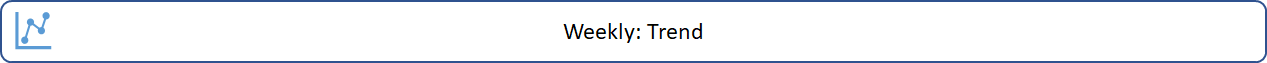

In [ ]:
fig = go.Figure(data=[go.Scatter(x=ds_weekly.index,y=ds_weekly.Sales)])
fig.update_layout(xaxis_title="Week",yaxis_title="Sales",title='Weekly Trend',height=400,template='ggplot2')
fig.show()

# Weekly: Test of Stationarity of Actual Series

In [ ]:
output = adfuller(ds_weekly.Sales)
print('***************************Week*********************************')
print('ADF Statistic: {0:.2f} and P value:{1:.5f}'.format(*output))
print("As we can see the p value is extreemly high which indicates that we are fail to reject null hypothesis " \
      "and can conclude that series is not stationary ")


# Weekly: Test of Stationarity with 1 differencing of series

In [ ]:
d=1
print('***************************Week*********************************')
# series = ds.Sales
series = ds_weekly.Sales.diff(d)# - ds.Sales.rolling(window=12).mean()
series = series.dropna()
output = adfuller(series)

print('ADF Statistic: {0:.2f} and P value:{1:.5f}'.format(*output))
print("As we can see the p value is close to zero which is less than .05 hence we reject null hypothesis and conclude " \
      " that series is stationary with rolling mean difference at lag of 12 ")

# Weekly: PACF & ACF

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series, ax=ax[0])
plot_pacf(series, ax=ax[1])
plt.show()


# Weekly: Train & Test Split

In [ ]:
series=ds_weekly.Sales
split_time = 45
time=np.arange(len(ds_weekly))
xtrain=series[:split_time]
xtest=series[split_time:]
timeTrain = time[:split_time]
timeTest = time[split_time:]
print('Full Set Size ',series.shape)
print('Training Set Size ',xtrain.shape)
print('Testing Set Size ',xtest.shape)

# Weekly: ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(xtrain, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
ytrain_pred = model_fit.predict()
ytest_pred = model_fit.predict(start=min(timeTest),end=max(timeTest),dynamic=True)
print('MSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain)**2)))
print('MSE Test :',np.sqrt(np.mean((ytest_pred - xtest)**2)))
forecast = model_fit.forecast(20, alpha=0.05)
plot_(t_train = timeTrain,t_test = timeTest,x_train = xtrain,x_test = xtest,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Weekly')

# WEEKLY: SARIMAX Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
s_model = SARIMAX(endog=xtrain , order=(1, 1, 2), seasonal_order=(1, 1, 1, 3), trend='c')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

In [ ]:
ytrain_pred = s_model_fit.predict()
ytest_pred = s_model_fit.predict(start=min(timeTest),end=max(timeTest),dynamic=True)
print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest)**2)))
forecast = s_model_fit.forecast(20, alpha=0.05)
plot_(t_train = timeTrain,t_test = timeTest,x_train = xtrain,x_test = xtest,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Weekly')

# Daily: Trend

In [ ]:
fig = go.Figure(data=[go.Scatter(x=ds_daily.Date,y=ds_daily.Sales)])
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Trend',height=400,template='ggplot2')
fig.show()

# Daily: Test of Stationarity of Actual Series

In [ ]:
print('\n***************************Daily*********************************')
output = adfuller(ds_daily.Sales)
print('ADF Statistic: {0:.2f} and P value:{1:.5f}'.format(*output))
print("As we can see the p value is extreemly high which indicates that we are fail to reject null hypothesis " \
      "and can conclude that series is not stationary ")

# Daily: Test of Stationarity with 1 differencing of series

In [ ]:
print('\n***************************Daily*********************************')
series_date = ds_daily.Sales.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and P value:{1:.5f}'.format(*output))
print("As we can see the p value is close to zero which is less than .05 hence we reject null hypothesis and conclude " \
      " that series is stationary with rolling mean difference at lag of 12 ")

# Daily: PACF & ACF

In [ ]:

fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0])
plot_pacf(series_date, ax=ax[1])
plt.show()


# Daily: Train & Test Split

In [ ]:
series_date=ds_daily.Sales
split_time = 250
time_d=np.arange(len(ds_daily))
xtrain_d=series_date[:split_time]
xtest_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',xtrain_d.shape)
print('Testing Set Size ',xtest_d.shape)

# Daily: ARIMA Model

In [ ]:
s_model = ARIMA(endog=xtrain_d , order=(1, 1, 1))
s_model_fit=s_model.fit()
print(s_model_fit.summary())

In [ ]:
ytrain_pred = s_model_fit.predict()
ytest_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('MSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = s_model_fit.forecast(20, alpha=0.05)

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = xtrain_d,x_test = xtest_d,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Daily')

# Daily: SARIMAX Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
s_model = SARIMAX(endog=xtrain_d , order=(1, 1, 1), seasonal_order=(1, 1, 2, 12), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

In [ ]:
ytrain_pred = s_model_fit.predict()
ytest_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('MSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = xtrain_d,x_test = xtest_d,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Daily')

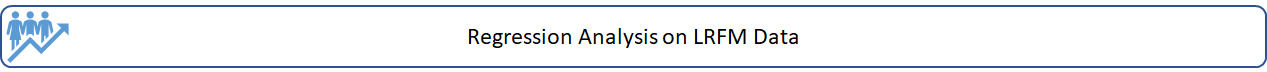

Now we are going to see a linear regression model based on features such as frequency and length of stay of customers which will predict Sales generated by customers.

In [ ]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.api import het_goldfeldquandt
from sklearn.metrics import r2_score

## Split the data

In [ ]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(LRFM[['Frequency', 'Length_of_stay']],LRFM.Monetary
                                             ,test_size=.3,random_state=49,shuffle=True)
print(xtrain1.shape)
print(xtest1.shape)


# Log Log Model

After several iteration I saw that Log-Log model seems better fit on the data which improves R square and following are all assumptions of regression. Please check chart of residual vs predicted for all assumption tests

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# poly = PolynomialFeatures(2)
# xtest = poly.fit_transform(xtest1)
# xtrain = poly.fit_transform(xtrain1)

inp_test=sm.add_constant(np.log1p(xtest1))
inp_train=sm.add_constant(np.log1p(xtrain1))
ytrain=np.log1p(ytrain1)
ytest=np.log1p(ytest1)
ols=sm.OLS(ytrain,inp_train)
model=ols.fit()
print(model.summary())

# Interpration

In [ ]:
print('Below are the interprataion of all 2 coeficients')
print('if customers increase the frequency of purchase by 1 percent then we can expect that sales will increase by 1.3%')
print('As customers are staying long with business then we can expect that sales will increase by 0.05%')

# Get Error

In [ ]:
ytrain_pred=model.predict(inp_train)
ytest_pred=model.predict(inp_test)

train_res=ytrain-ytrain_pred
test_res=ytest-ytest_pred

train_mse= np.mean(train_res**2)
test_mse= np.mean(test_res**2)

print('Train MSE:{0:.4f}'.format(train_mse))
print('Test MSE:{0:.4f}'.format(test_mse))


# Get R square

In [ ]:
r2_train=r2_score(ytrain,ytrain_pred)
r2_test=r2_score(ytest,ytest_pred)
print('R square Train:{0:.4f}'.format(r2_train))
print('R square Test:{0:.4f}'.format(r2_test))

# Linearrainbow test

H0 : Part of the data is Linear

Ha : Independent features does not have linear relation with target feature

In [ ]:
pval=linear_rainbow(res=model,frac=0.5)[1]
print('P value {0:.2f}'.format(pval))

# Homoscadastic -- Uniform variance
H0 : model is Homoscadastic

Ha : model is Heteroskedastic

In [ ]:
homoscad = het_goldfeldquandt(train_res,inp_train)[1]
print('P Value {0:.2f}'.format(homoscad))

# Plot between Actual and predicted to check relationship

In [ ]:
fig = make_subplots(rows=1, cols=2,subplot_titles=['Train','Test'])
fig.add_trace(go.Scatter(x=ytrain,y=ytrain_pred, mode='markers'
                         ,marker=dict(size=4,colorscale='Viridis',opacity=0.8)),row=1, col=1)
fig.add_trace(go.Scatter(x=ytest,y=ytest_pred, mode='markers'
                         ,marker=dict(size=4,colorscale='Viridis',opacity=0.8)),row=1, col=2)
fig.update_xaxes(title_text="Actual", row=1, col=1)
fig.update_yaxes(title_text="Predicted", row=1, col=1)
fig.update_xaxes(title_text="Actual", row=1, col=2)
fig.update_yaxes(title_text="Predicted", row=1, col=2)
fig.update_layout(height=400, width=800,template='ggplot2')
fig.show()

# Test of Assumptions of Regression

To meet all assumptions of linear regression below are the criteria must be followed
1. **Normality** - Error Must be normally distributed 
    
    * To test this assumption, we can run statistical tests or simply can take skewness of residual and can accept it as normally distributed if skewness is -.5 to +.5
    
2. **Independence** - Residual must not be autocorrelated 
    * To test this assumption, we can check Durbin Watson value 
        * if it is = 2, then there is no autocorrelation among residual points.
        * if it is 0< Durbin Watson <2 then there is Positive autocorrelation
        * if it is 2< Durbin Watson <4. Negative auto correlation
    * For standard practice Durbin Watson value between 1.5 and 2.5 is acceptable range to pass this test
3. **Homoscedasticity** - There should be uniform variance in error with respect target variable
4. **Linearity** -The relationship between X and the mean of Y is linear.



In [ ]:
textstr = "<br>".join(("SKEW={:.2f}".format(train_res.skew())
                     ,'Linearity Test P value={:.2f}'.format(pval)
                    ,'Homoscadastic Test P value={:.2f}'.format(homoscad)
                    ,'Durbin Watson value = {:.2f}'.format(durbin_watson(train_res))
                    ,'Train MSE ={:.3f}'.format(train_mse)
                    ,'Test MSE ={:.3f}'.format(test_mse)
                    ,'R square Train ={:.3f}'.format(r2_train)
                    ,'R square Test ={:.3f}'.format(r2_test)))

fig= px.scatter(x=ytrain,y=train_res,marginal_y="histogram",
               marginal_x="histogram", trendline="ols")

fig.update_layout(title="Test of Assumptions",xaxis_title="Predicted",yaxis_title="Residual",
                            font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.add_annotation(x=4,y=4,xref="x",yref="y",text=textstr,showarrow=False,font=dict(size=10)
                   ,align="left",ax=20,ay=-30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="snow",opacity=0.8)
fig.show()

Conclusion:
This is lot of scope in EDA as well as in modeling, which I will try in my next version of same analysis. Feel free to provide your thought and feedback.

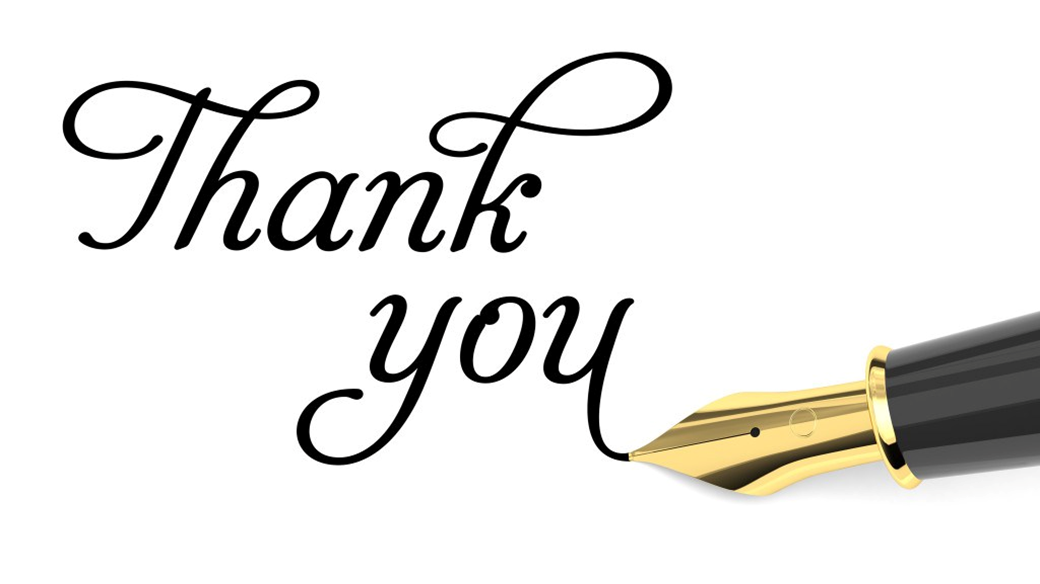